In [1]:
import torch
import torchvision
import time
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#for nvidia 
has_gpu = torch.cuda.is_available()
#for mac
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "cuda" if torch.cuda.is_available() else "cpu"

print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

random_seed = 1
batch_size = 128
num_epochs = 15
num_classes = 5

GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda


In [7]:
train_data_transform_example = torchvision.transforms.Compose([
    torchvision.transforms.Resize((132, 132)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    ])

#train_dataset = datasets.CIFAR10('./CIFAR10/', train=True, transform=train_data_transform_example, download=True)
train_data_dir = 'Data Set/Data_Without_noice/data/new_data/Train1'
train_dataset = ImageFolder(root=train_data_dir, transform=train_data_transform_example)


train_loader_example = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=False
)

batch_mean_list = []
batch_std_list = []

for ii, image in enumerate(train_loader_example, 0):
    np_image = image[0].numpy()
    batch_mean = np.mean(np_image, axis=(0, 2, 3))
    batch_std = np.std(np_image, axis=(0, 2, 3))
    
    batch_mean_list.append(batch_mean)
    batch_std_list.append(batch_std)
train_mean = np.mean(batch_mean_list, axis=0)
train_std = np.mean(batch_std_list, axis=0)

print('Mean of all train images:', train_mean)
print('Std Dev of all train images:', train_std)

Mean of all train images: [0.7770973  0.5562024  0.72680366]
Std Dev of all train images: [0.13983124 0.17558719 0.12780875]


In [3]:
train_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((132, 132)),
    torchvision.transforms.RandomHorizontalFlip(0.5),
    torchvision.transforms.RandomCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.777, 0.556, 0.727), (0.140, 0.176, 0.127))
    ])

test_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((132, 132)),        
    torchvision.transforms.CenterCrop((128, 128)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.777, 0.556, 0.727), (0.140, 0.176, 0.127))
    ])

In [4]:
#train_dataset = ImageFolder(root="mnist-imgs/train", transform=train_data_transform)
#test_dataset = ImageFolder(root="mnist-imgs/test", transform=test_data_transform)
'''
train_dataset = datasets.CIFAR10('./CIFAR10/', train=True, transform=train_data_transform, download=True)
test_dataset = datasets.CIFAR10('./CIFAR10/', train=False, transform=test_data_transform, download=True)
'''
# Set paths to your train and test data directories
train_data_dir = 'Data Set/Data_Without_noice/data/new_data/Train1'
test_data_dir = 'Data Set/Data_Without_noice/data/new_data/Test1'

# Load train and test datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_data_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_data_transform)

print(len(train_dataset))

train_dataset, valid_dataset = random_split(train_dataset, lengths=[18000, 3097])

21097


In [6]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=False
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 3, 128, 128])


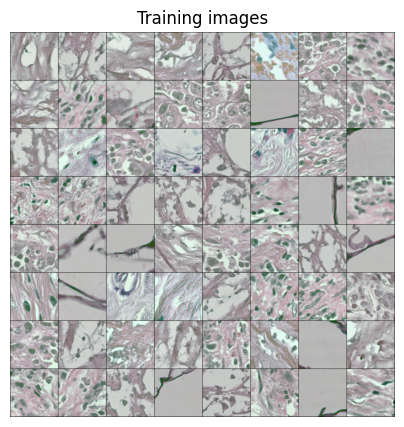

Labels = 
[[1 1 1 1 1 2 4 3]
 [1 3 0 4 4 0 1 4]
 [1 2 4 2 1 2 4 0]
 [3 3 1 1 1 3 2 3]
 [4 0 0 1 4 3 1 0]
 [2 0 2 2 1 3 3 2]
 [4 1 1 1 3 1 0 1]
 [3 3 1 0 1 3 0 3]]


In [7]:
import torchvision.utils as vutils

%matplotlib inline
import matplotlib.pyplot as plt

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))

In [8]:
from torchvision.models import resnet50, ResNet50_Weights
#from torchsummary import summary
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Print the model
#print(model)

In [9]:
# Freeze the layers you do not want to update
#for param in model.parameters():
#    param.requires_grad = False

# Unfreeze layers you want to update
#model.fc.rerquires_grad = True

# Add new layers
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(128, num_classes),
)

In [10]:
summary(model, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 5]                  --
├─Conv2d: 1-1                            [128, 64, 64, 64]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 64, 64]         128
├─ReLU: 1-3                              [128, 64, 64, 64]         --
├─MaxPool2d: 1-4                         [128, 64, 32, 32]         --
├─Sequential: 1-5                        [128, 256, 32, 32]        --
│    └─Bottleneck: 2-1                   [128, 256, 32, 32]        --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         4,096
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-3                    [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-6                    [128, 64, 32, 32]         --
│ 

In [11]:
#model = nn.DataParallel(model)
model = model.to(device)
#model

In [12]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc.detach().cpu().numpy()

In [13]:
def losses(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)
    return loss.detach().cpu().numpy()

In [14]:
train_accs = []
valid_accs = []
test_accs = []
train_losses = []
valid_losses = []
test_losses = []

In [15]:
torch.manual_seed(random_seed)
base_learning_rate = 1e-5 # for fine-tuning - low learning rates
fc_learning_rate = 1e-2

# Set different learning rates for different param_groups
optimizer = torch.optim.Adam([
    {'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, 
    {'params': model.fc.parameters(), 'lr': fc_learning_rate, 'weight_decay':0.5}
    ], lr=base_learning_rate)
# Set up a Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [16]:
start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)

        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        # Print Performance every 100 mini-batches
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:02d}/{num_epochs:02d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.5f}"
            )
    # capture training loss
    train_losses.append(loss.detach().cpu().numpy())
    
    # Tracking the Learning Rate Scheduler
    prev_lr_base = optimizer.param_groups[0]["lr"]
    prev_lr_fc = optimizer.param_groups[1]["lr"]
    scheduler.step()
    current_lr_base = optimizer.param_groups[0]["lr"]
    current_lr_fc = optimizer.param_groups[1]["lr"]
    print(f"Epoch: {epoch+1:03d} Base Learning Rate {prev_lr_base:.8f} -> {current_lr_base:.8f}")
    print(f"Epoch: {epoch+1:03d} FC Learning Rate {prev_lr_fc:.8f} -> {current_lr_fc:.8f}")

    #Evaluate validation and test Loss after each epoch
    model = model.eval()
    valid_loss = losses(model, valid_loader, device)
    valid_losses.append(valid_loss)

    test_loss = losses(model, test_loader, device)
    test_losses.append(test_loss)
    
    
    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, train_loader, device)
    train_accs.append(tr_acc)
    valid_acc = accuracy(model, valid_loader, device)
    valid_accs.append(valid_acc)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    ts_acc = accuracy(model, test_loader, device)
    test_accs.append(ts_acc)
    print(f"Test Accuracy: {ts_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min")

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")

Epoch: 01/15 | Batch: 100/140 | Loss: 0.41138
Epoch: 001 Base Learning Rate 0.00001000 -> 0.00001000
Epoch: 001 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 87.640
Validation Accuracy: 88.279
Test Accuracy: 82.963
Time elapsed so far: 1.90 min
Epoch: 02/15 | Batch: 100/140 | Loss: 0.28485
Epoch: 002 Base Learning Rate 0.00001000 -> 0.00001000
Epoch: 002 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 91.657
Validation Accuracy: 92.251
Test Accuracy: 86.788
Time elapsed so far: 3.80 min
Epoch: 03/15 | Batch: 100/140 | Loss: 0.23762
Epoch: 003 Base Learning Rate 0.00001000 -> 0.00001000
Epoch: 003 FC Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 92.344
Validation Accuracy: 92.541
Test Accuracy: 86.877
Time elapsed so far: 5.70 min
Epoch: 04/15 | Batch: 100/140 | Loss: 0.21176
Epoch: 004 Base Learning Rate 0.00001000 -> 0.00000500
Epoch: 004 FC Learning Rate 0.01000000 -> 0.00500000
Train Accuracy: 93.700
Validation Accuracy: 93.736
Test Accuracy: 87.900
Ti

In [17]:
ts_acc = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")

Test Accuracy: 89.235


In [18]:
def plot_accuracy(train_accs, valid_accs, test_accs):
    epochs = len(train_accs)
    plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), valid_accs, label='Validation Accuracy')
    plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.show()

In [19]:
def plot_loss(train_losses, valid_losses, test_losses):
    epochs = len(train_losses)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

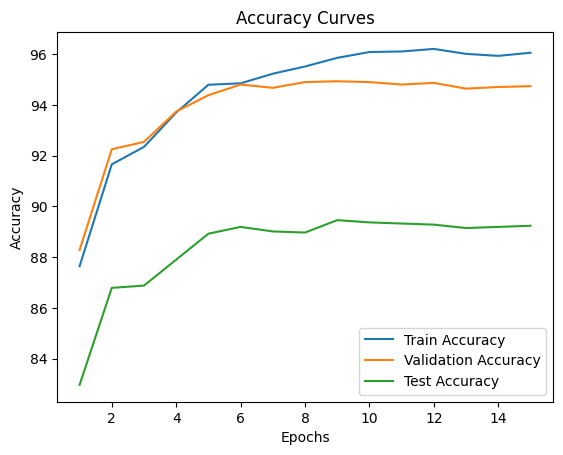

In [20]:
plot_accuracy(train_accs, valid_accs, test_accs)

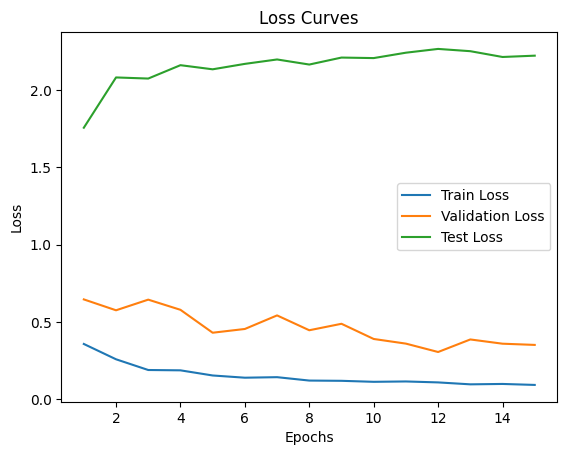

In [21]:
plot_loss(train_losses, valid_losses, test_losses)

In [22]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

In [23]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)
    num_classes = len(classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes)
    
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j + 0.5, i + 0.5, cm[i, j], ha='center', va='center', color='black')
    
    
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

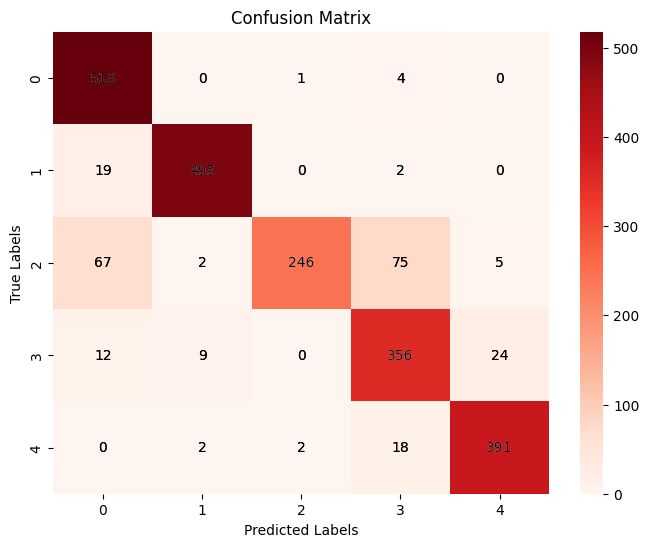

In [24]:
plot_confusion_matrix(true_labels, predicted_labels, classes=[str(i) for i in range(num_classes)])